In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pycbc.detector
from pycbc import psd as psd_func
from pycbc.filter import sigma
from pycbc.noise import frequency_noise_from_psd
from simple_pe.waveforms import make_waveform

# Disable pesummary warnings
import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)

# Otherwise plt.savefig crashes with latex errors
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [110]:
# noise_seeds = None will not add noise
# noise_seeds = {'H1': None, 'L1': None, etc. will add noise with random seeds
# noise_seeds = {'H1': SEED_H1, 'L1': SEED_L1, etc. will add noise with specified seeds

def gen_data_psds(parameters, location, ifos, psds, target_snr, noise_seeds=None):

    # Generate psd for each detector and harmonic mean
    psd = {}
    for ifo in ifos:
        psd[ifo] = psd_func.analytical.from_string(psds[ifo], psds['length'] * psds['f_high'] + 1, psds['delta_f'],
                                                   psds['f_low'])
    psd['harm'] = 1. / sum([1. / psd[ifo] for ifo in ifos])

    # Make base waveform for data
    parameters['distance'] = 1
    hp, hc = make_waveform(parameters.copy(), psd['harm'].delta_f, f_low, len(psd['harm']), approximant='TEOBResumS-Dali', return_hc=True)
    hp, hc = hp.to_timeseries(), hc.to_timeseries()

    # Loop over each detector
    initial_snr_sqrd = 0
    data = {}
    for ifo in ifos:

        # Apply response function
        det = pycbc.detector.Detector(ifo)
        fp, fc = det.antenna_pattern(location['ra'], location['dec'], location['psi'], location['t_gps'])
        ifo_data = fp*hp - 1j*fc*hc
        ifo_data.start_time += det.time_delay_from_earth_center(location['ra'], location['dec'], location['t_gps'])

        # Calculate SNR
        initial_snr_sqrd += sigma(ifo_data.real(), psd[ifo], low_frequency_cutoff=psds['f_low'], high_frequency_cutoff=psds['f_high'])**2
        data[ifo] = ifo_data

    # Change SNR to target and add noise if requested
    for ifo in ifos:
        data[ifo] *= target_snr/np.sqrt(initial_snr_sqrd)

        if noise_seeds is not None:
            noise = frequency_noise_from_psd(psd[ifo], seed=noise_seeds[ifo]).to_timeseries()
            noise.start_time = data[ifo].start_time
            data[ifo] += noise

    return data, psd

In [118]:
# Data/psd settings
parameters = {'ecc10sqrd': 0.2**2, 'chirp_mass': 24, 'symmetric_mass_ratio': 2/9, 'chi_eff': 0}
location = {'ra': 1, 'dec': 2, 'psi': 1, 't_gps': 1126279462.0}
f_low = 20
sample_rate = 4096
tlen = 32
ifos = ['H1', 'L1', 'V1']
psds = {'H1': 'aLIGO175MpcT1800545',
        'L1': 'aLIGO175MpcT1800545',
        'V1': 'AdVO3LowT1800545',
        'f_low': f_low,
        'f_high': int(sample_rate/2),
        'length': tlen,
        'delta_f': 1. / tlen
        }

# Calculate data and psd for each detector
noise_seeds = None
# noise_seeds = {'H1': None, 'L1': None, 'V1': None
data, psd = gen_data_psds(parameters, location, ifos, psds, 20, noise_seeds=noise_seeds)

SNR of 12.40 in H1
SNR of 14.96 in L1
SNR of 4.74 in V1


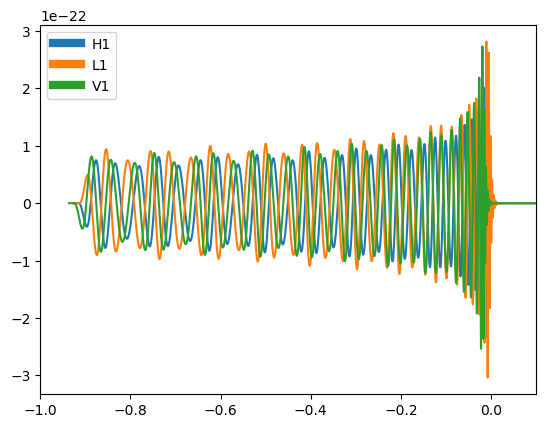

In [119]:
# Calculate SNR in each detector
for ifo in ifos:
    snr = sigma(data[ifo].real(), psd[ifo], low_frequency_cutoff=psds['f_low'], high_frequency_cutoff=psds['f_high'])
    print(f'SNR of {snr:.2f} in {ifo}')

# Make plot
for ifo in ifos:
    plt.plot(data[ifo].sample_times, data[ifo], label=ifo)
plt.xlim(-1, 0.1)
plt.legend()
plt.show()